TP2

Nom: Thierno Ibrahima Cissé
Code MS: CIST26029707

# Harris Corner Detector

In [169]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import signal as sig


def describe_point(im: np.ndarray, pos: list) -> dict:
    """Crée un descripteur de caractéristique pour un point l'image
    Parameters
    ----------
    im: ndarray
        Image source
    pos: (2,) list
        Position (r,c) dans l'image qu'on souhaite décrire
    Returns
    -------
    d: dict
        Descripteur pour cet indice.
    """
    r = 2 # Rayon du voisinage
    
    # Descripteur
    d = dict()
    d["pos"] = pos
    d["n"] = (2*r + 1)**2*im.shape[2] # Nombre de valeurs dans le descripteur
    d["data"] = np.zeros((d["n"],), dtype=float)

    # Valeur du pixel central
    cval = im[pos[0], pos[1], :]

    # Limite du voisinage
    r0 = pos[0] - r if pos[0] - r > 0 else 0
    r1 = pos[0] + r + 1 if pos[0] + r + 1 < im.shape[0] else im.shape[0]-1
    c0 = pos[1] - r if pos[1] - r > 0 else 0
    c1 = pos[1] + r + 1 if pos[1] + r + 1 < im.shape[1] else im.shape[1]-1

    # Extraction et normalisation des valeurs
    values = (im[r0:r1, c0:c1, :].astype(float) - cval).ravel()

    # Intégration dans le descripteur
    d['data'][0:len(values)] = values

    return d

def mark_spot(im: np.ndarray, p: list, color: list = [255,0,255]) -> np.ndarray:
    """ Marque la position d'un point dans l'image.
    Parameters
    ----------
    im: ndarray
        Image à marquer
    p: (2,) list
        Position (r,c) du point
    color: (3,) list
        Couleur de la marque
    Returns
    -------
    im: ndarray
        Image marquée.
    """
    r = p[0]
    c = p[1]

    for i in range(-9,10):
        if r+i < 0 or r+i >= im.shape[0] or c+i < 0 or c+i >= im.shape[1]:
            continue # ce pixel est à l'extérieur de l'image
        im[r+i, c, 0] = color[0]
        im[r+i, c, 1] = color[1]
        im[r+i, c, 2] = color[2]
        im[r, c+i, 0] = color[0]
        im[r, c+i, 1] = color[1]
        im[r, c+i, 2] = color[2]

    return im

def mark_corners(im: np.ndarray, d: list, n: int) -> np.ndarray:
    """ Marks corners denoted by an array of descriptors.
    Parameters
    ----------
    im: ndarray
        Image à marquer
    d: list
        Coins dans l'image
    n: int
        Nombre de descripteurs à marquer
    Returns
    -------
    im: ndarray
        Image marquée
    """
    m = np.copy(im)
    for i in range(n):
        m = mark_spot(m, d[i]['pos'])
    return m

def smooth_image(im: np.ndarray, sigma: float) -> np.ndarray:
    """Lissage d'une image avec un filtre gaussien.
    Parameters
    ----------
    im: ndarray
        Image à traiter
    sigma: float
        Écart-type pour la gaussienne.
    Returns
    -------
    s: ndarray
        Image lissée
    """
    s = gaussian_filter(im, sigma)
    return s

def structure_matrix(im: np.ndarray, sigma: float) -> np.ndarray:
    """Calcul du tenseur de structure d'un image.
    Parameters
    ----------
    im: ndarray
        Image à traiter (tons de gris et normalisée entre 0 et 1).
    sigma: float
        Écart-type pour la somme pondérée
    Returns
    -------
    S: ndarray
        Tenseur de structure. 1er canal est Ix^2, 2e canal est Iy^2
        le 3e canal est IxIy
    """
    S = np.zeros((*im.shape,3))

    # TODO: calcul du tenseur de structure pour im.

    # Sobel operator kernels
    sobel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # x and y image derivate
    Ix = sig.convolve2d(im, sobel_x, mode='same', boundary='symm')
    Iy = sig.convolve2d(im, sobel_y, mode='same', boundary='symm')

    # metrics calculation
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy

    # matrix construction
    my_matrix = np.zeros((*im.shape,3))
    my_matrix[::, ::, 0] = Ixx[::, ::]
    my_matrix[::, ::, 1] = Iyy[::, ::]
    my_matrix[::, ::, 2] = Ixy[::, ::]
    
    # Tensor setup
    S = smooth_image(my_matrix, sigma)

    # plt.subplot(121); plt.imshow(Ix, cmap='gray'); plt.title('Ix')
    # plt.subplot(122); plt.imshow(Iy, cmap='gray'); plt.title('Iy')
    # plt.show()

    # plt.subplot(121); plt.imshow(Ixx, cmap='gray'); plt.title('Ixx')
    # plt.subplot(122); plt.imshow(Iyy, cmap='gray'); plt.title('Iyy')
    # plt.show()

    # plt.imshow(Ixy, cmap='gray'); plt.title('Ixy')
    # plt.show()

    # plt.imshow(S, cmap='gray'); plt.title('tensor')
    # plt.show()
    
    return S

def cornerness_response(S: np.ndarray) -> np.ndarray:
    """Estimation du cornerness de chaque pixel avec le tenseur de structure S.
    Parameters
    ----------
    S: ndarray
        Tenseur de structure de l'image
    Returns
    -------
    R: ndarray
        Une carte de réponse de la cornerness
    """
    R = np.zeros(S.shape[0:2])

    # TODO: Remplir R avec la "cornerness" pour chaque pixel en utilisant le tenseur de structure
    # On utilise la formulation det(S) - alpha * trace(S)^2, alpha = 0.06

    alpha = 0.06

    # Determinant calculation
    detS = S[...,0] * S[...,1] - S[...,2]**2

    # trace calculation
    traceS = S[...,0] + S[...,1]

    # response for each pixel
    R = detS - alpha * traceS**2

    # plt.imshow(R, cmap='gray'); plt.title('response')
    # plt.show()

    return R

def nms_image(im: np.ndarray, w: int) -> np.ndarray:
    """Effectue la supression des non-maximum sur l'image des feature responses.
    Parameters
    ----------
    im: ndarray
        Image 1 canal des réponses de caractéristiques (feature response)
    w: int
        Distance à inspecter pour une grande réponse
    Returns
    -------
    r: ndarray
        Image contenant seulement les maximums locaux pour un voisinage de w pixels.
    """
    r = np.copy(im)

    # TODO: faire NMS sur la carte de réponse
    # Pour chaque pixel dans l'image:
    #     Pour chaque voisin dans w:
    #         Si la réponse du voisin est plus grande que la réponse du pixel:
    #             Assigner à ce pixel une très petite réponse (ex: -np.inf)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        for row in range(-w-1, w+1):
          for col in range(-w-1, w+1):
            try:
              if r[i,j] < r[i+row, j+col]:
                r[i,j] = -np.inf
            except IndexError:
              pass

    # plt.imshow(r, cmap='gray'); plt.title('nms')
    # plt.show()

    return r

def harris_corner_detector(im: np.ndarray, sigma: float, thresh: float, nms: int) -> np.ndarray:
    """ Détecteur de coin de Harris, et extraction des caractéristiques autour des coins.
    Parameters
    ----------
    im: ndarray
        Image à traiter (RGB).
    sigma: float
        Écart-type pour Harris.
    thresh: float
        Seuil pour le cornerness
    nms: int
        Distance maximale à considérer pour la supression des non-maximums
    Returns
    -------
    d: list
        Liste des descripteurs pour chaque coin dans l'image
    """
    img = im.mean(axis=2) # Convert to grayscale
    img = (img.astype(float) - img.min()) / (img.max() - img.min())

    # Calculate structure matrix
    S = structure_matrix(img, sigma)

    # Estimate cornerness
    R = cornerness_response(S)

    # Run NMS on the responses
    Rnms = nms_image(R, nms)

    # TODO: Comptez le nombre de réponses au-dessus d'un seuil thresh

    count = 0 # changez ceci

    points = []
    for i in range(Rnms.shape[0]):
      for j in range(Rnms.shape[1]):
        if Rnms[i,j] > thresh:
          count = count + 1
          points.append((i,j))

    # print(count)

    n = count # <- fixer n = nombre de coins dans l'image
    d = []

    # TODO: remplir le tableau d avec le descripteur de chaque coin. Utilisez describe_point()

    for i in range(n):
      d.append(describe_point(im, points[i]))
    
    return d

def detect_and_draw_corners(im: np.ndarray, sigma: float, thresh: float, nms: int) -> np.ndarray:
    """ Trouve et dessine les coins d'une image
    Parameters
    ----------
    im: ndarray
        L'image à traiter (RGB).
    sigma: float
        Écart-type pour Harris.
    thresh: float
        Seuil pour le cornerness.
    nms: int
        Distance maximale à considérer pour la supression des non-maximums
    Returns
    m: ndarray
        Image marqué avec les coins détectés
    """
    d = harris_corner_detector(im, sigma, thresh, nms)
    m = mark_corners(im, d, len(d))
    return m

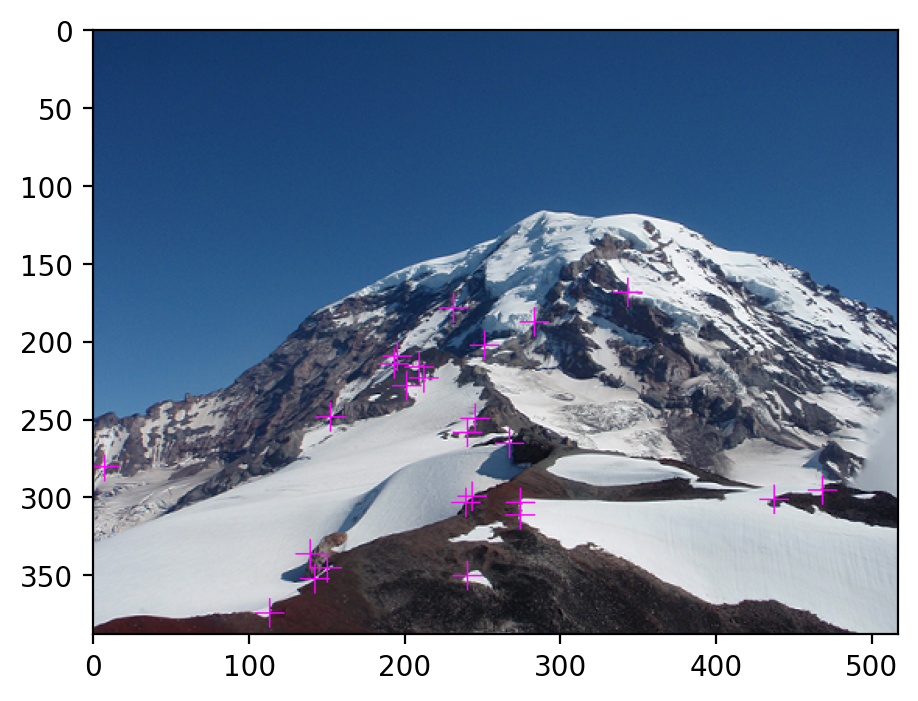

In [307]:
import imageio as imgio
import matplotlib.pyplot as plt

image = imgio.imread('/content/Rainier1.png')
im_cd = detect_and_draw_corners(image, 2, 0.04, 3)
plt.figure(dpi=200)
plt.imshow(im_cd); plt.show()

# Panorama

In [242]:
def nearest_neighbour(im: np.ndarray, point: list, channel: int) -> float:
  return im[round(point[0]), round(point[1]), channel]

In [287]:
from math import sqrt
from random import randrange


def make_translation_homography(dr: float, dc: float) -> np.ndarray:
    """Create a translation homography
    Parameters
    ----------
    dr: float
        Translation along the row axis
    dc: float
        Translation along the column axis
    Returns
    -------
    H: np.ndarray
        Homography as a 3x3 matrix
    """
    H = np.zeros((3,3))
    H[0,0] = 1
    H[1,1] = 1
    H[2,2] = 1
    H[0,2] = dr # Row translation
    H[1,2] = dc # Col translation

def match_compare(a: float, b: float) -> int:
    """ Comparator for matches
    Parameters
    ----------
    a,b : float
        distance for each match to compare.
    Returns
    -------
    result of comparison, 0 if same, 1 if a > b, -1 if a < b.
    """
    comparison = 0
    if a < b:
        comparison = -1
    elif a > b:
        comparison = 1
    else:
        comparison
    return comparison

def both_images(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """ Place two images side by side on canvas, for drawing matching pixels.
    Parameters
    ----------
    a,b: ndarray
        Images to place
    Returns
    -------
    c: ndarray
        image with both a and b side-by-side.
    """
    width = a.shape[1] + b.shape[1]
    height = a.shape[0] if a.shape[0] > b.shape[0] else b.shape[0]
    channel = a.shape[2] if a.shape[2] > b.shape[2] else b.shape[2]
    
    both = np.zeros((height,width,channel), dtype=a.dtype)
    both[0:a.shape[0], 0:a.shape[1],0:a.shape[2]] = a
    both[0:b.shape[0], a.shape[1]:a.shape[1]+b.shape[1],0:b.shape[2]] = b
    
    return both

def draw_matches(a: np.ndarray, b: np.ndarray, matches: list, inliers: int) -> np.ndarray:
    """Draws lines between matching pixels in two images.
    Parameters
    ----------
    a, b: ndarray
        two images that have matches.
    matches: list
        array of matches between a and b.
    inliers: int
        number of inliers at beginning of matches, drawn in green.
    Returns
    -------
    c: ndarray
        image with matches drawn between a and b on same canvas.
    """
    both = both_images(a, b)
    n = len(matches)
    for i in range(n):
        r1 = matches[i]['p'][0] # Coordonnée y du point p
        r2 = matches[i]['q'][0] # Coordonnée y du point q
        c1 = matches[i]['p'][1] # Coordonnée x du point p
        c2 = matches[i]['q'][1] # Coordonnée x du point q
        for c in range(c1, c2 + a.shape[1]):
            r = int((c-c1)/(c2 + a.shape[1] - c1)*(r2 - r1) + r1)
            both[r, c, 0] = (0 if i<inliers else 255)
            both[r, c, 1] = (255 if i<inliers else 0)
            both[r, c, 2] = 0
    return both

def draw_inliers(a: np.ndarray, b: np.ndarray, H: np.ndarray, matches: list, thresh: float) -> np.ndarray:
    """ Draw the matches with inliers in green between two images.
    Parameters
    ----------
    a, b: ndarray
        two images to match.
    H: ndarray
        Homography matrix
    matches: list
        array of matches between a and b
    thresh: float
        Threshold to define inliers
    Returns
    -------
    lines: ndarray
        Modified images with inliers
    """
    n_inliers, new_matches = model_inliers(H, matches, thresh)
    lines = draw_matches(a, b, new_matches, n_inliers)
    return lines


def find_and_draw_matches(a: np.ndarray, b: np.ndarray, sigma: float=1, thresh: float=0.99, nms: int=3) -> np.ndarray:
    """ Find corners, match them, and draw them between two images.
    Parameters
    ----------
    a, b: np.ndarray
         images to match.
    sigma: float
        gaussian for harris corner detector. Typical: 2
    thresh: float
        threshold for corner/no corner. Typical: 1-5
    nms: int
        window to perform nms on. Typical: 3
    Returns
    -------
    lines: np.ndarray
        Images with inliers
    """
    ad = harris_corner_detector(a, sigma, thresh, nms)
    bd = harris_corner_detector(b, sigma, thresh, nms)
    m = match_descriptors(ad, bd)

    a = mark_corners(a, ad, len(ad))
    b = mark_corners(b, bd, len(bd))
    lines = draw_matches(a, b, m, 0)

    return lines

def l1_distance(a: np.ndarray, b: np.ndarray) -> float:
    """Calculates L1 distance between to floating point arrays.
    Parameters
    ----------
    a, b: list or np.ndarray
        arrays to compare.
    Returns
    -------
    l1: float
        l1 distance between arrays (sum of absolute differences).
    """

    #TODO: return the correct number

    l1 = np.sum(np.abs(np.subtract(a, b).astype(float)))

    return l1


def match_descriptors(a: list, b: list) -> list:
    """Finds best matches between descriptors of two images.
    Parameters
    ----------
    a, b: list
        array of descriptors for pixels in two images.
    Returns
    -------
    matches: list
        best matches found. each descriptor in a should match with at most
        one other descriptor in b.
    """
    an = len(a)
    bn = len(b)
    matches = []
    for j in range(an):

        # TODO: for every descriptor in a, find best match in b.
        # record ai as the index in a and bi as the index in b.

        bind = 0 # <- find the best match
        
        min_distance = l1_distance(a[j]['data'], b[0]['data'])
        for i in range(bn):
          new_distance = l1_distance(a[j]['data'], b[i]['data'])
          if new_distance < min_distance :
            min_distance = new_distance
            bind = i

        matches.append({})
        matches[j]['ai'] = j
        matches[j]['bi'] = bind # <- should be index in b.
        matches[j]['p'] = a[j]['pos']
        matches[j]['q'] = b[bind]['pos']
        matches[j]['distance'] = min_distance # <- should be the smallest L1 distance!
    
    seen = []
    filtered_matches = []
    # TODO: we want matches to be injective (one-to-one).
    # Sort matches based on distance using match_compare and sort.
    # Then throw out matches to the same element in b. Use seen to keep track.
    # Each point should only be a part of one match.
    # Some points will not be in a match.
    # In practice just bring good matches to front of list.

    matches.sort(key=lambda x:x['distance'])

    for k in matches:
      if k['bi'] not in seen:
        filtered_matches.append(k)
        seen.append(k)

    matches = filtered_matches

    return matches

def project_point(H, p):
    """ Apply a projective transformation to a point.
    Parameters
    ----------
    H: np.ndarray
        homography to project point, of shape 3x3
    p: list
        point to project.
    Returns
    -------
    q: list
        point projected using the homography.
    """

    c = np.zeros((3, 1))
    # TODO: project point p with homography H.
    # Remember that homogeneous coordinates are equivalent up to scalar.
    # Have to divide by.... something...

    c[0] = p[0]
    c[1] = p[1]
    c[2] = 1

    produit = np.matmul(H, c)

    q = [produit[0][0]/produit[2][0] , produit[1][0]/produit[2][0]]

    return q

def point_distance(p, q):
    """ Calculate L2 distance between two points.
    Parameters
    ----------
    p, q: list
        points.
    Returns
    -------
    l2: float
        L2 distance between them.
    """
    
    # TODO: should be a quick one
    
    l2 = sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

    return l2

def model_inliers(H: np.ndarray, matches: list, thresh: float) -> tuple:
    """Count number of inliers in a set of matches. Should also bring inliers to the front of the array.
    Parameters
    ----------
    H: np.ndarray
        homography between coordinate systems.
    matches: list
        matches to compute inlier/outlier.
    thresh: float
        threshold to be an inlier.
    Returns
    -------
    count: int
        number of inliers whose projected point falls within thresh of their match in the other image.
    matches: list
        Should also rearrange matches so that the inliers are first in the array. For drawing.
    """
    count = 0
    new_matches = [] # To reorder the matches
    # TODO: count number of matches that are inliers
    # i.e. distance(H*p, q) < thresh
    # Also, sort the matches m so the inliers are the first 'count' elements.

    for match in matches:
      point = project_point(H, match['p'])
      if point_distance(point, match['q']) < thresh:
        new_matches.insert(0, match)
        count +=1
      else:
        new_matches.append(match)

    return (count, new_matches)

def randomize_matches(matches: list) -> list:
    """ Randomly shuffle matches for RANSAC.
    Parameters
    ----------
    matches: list
        matches to shuffle in place
    Returns
    -------
    shuffled_matches: list
        Shuffled matches
    """
    # TODO: implement Fisher-Yates to shuffle the array.

    for i in range(len(matches)-1, 0, -1):
      j = randrange(i + 1)
      matches[i], matches[j] = matches[j], matches[i]

    return matches


def compute_homography(matches: list, n: int) -> np.ndarray:
    """Computes homography between two images given matching pixels.
    Parameters
    ----------
    matches: list
        matching points between images.
    n: int
        number of matches to use in calculating homography.
    Returns
    -------
    H: np.ndarray
        matrix representing homography H that maps image a to image b.
    """
    assert n >= 4, "Underdetermined, use n>=4"

    M = np.zeros((n*2,8))
    b = np.zeros((n*2,1))

    for i in range(n):
      r  = float(matches[i]['p'][0])
      rp = float(matches[i]['q'][0]) 
      c  = float(matches[i]['p'][1])
      cp = float(matches[i]['q'][1])

        # TODO: fill in the matrices M and b.

      M[i*2, 0] = r
      M[i*2, 1] = c
      M[i*2, 2] = 1
      M[i*2, 6] = -r*rp
      M[i*2, 7] = -c*rp

        
      M[i*2+1, 3] = r
      M[i*2+1, 4] = c
      M[i*2+1, 5] = 1
      M[i*2+1, 6] = -r*cp
      M[i*2+1, 7] = -c*cp

      b[i*2, 0] = rp
      b[i*2+1, 0] = cp

    # Solve the linear system
    if M.shape[0] == M.shape[1]:
        a = np.linalg.solve(M, b)
    else: # Over-determined, using least-squared
        a = np.linalg.lstsq(M,b,rcond=None)
        a = a[0]
    # If a solution can't be found, return empty matrix;
    if a is None:
        return None

    H = np.zeros((3,3))
    # TODO: fill in the homography H based on the result in a.

    H[0, 0] = a[0, 0]
    H[0, 1] = a[1, 0]
    H[0, 2] = a[2, 0]
    H[1, 0] = a[3, 0]
    H[1, 1] = a[4, 0]
    H[1, 2] = a[5, 0]
    H[2, 0] = a[6, 0]
    H[2, 1] = a[7, 0]
    H[2, 2] = 1

    return H

def RANSAC(matches: list, thresh: float, k: int, cutoff: int):
    """Perform RANdom SAmple Consensus to calculate homography for noisy matches.
    Parameters
    ----------
    matches: list
        set of matches.
    thresh: float
        inlier/outlier distance threshold.
    k: int
        number of iterations to run.
    cutoff: int
        inlier cutoff to exit early.
    Returns
    -------
    Hb: np.ndarray
        matrix representing most common homography between matches.
    """
    best = 0
    Hb = make_translation_homography(0, 256) # Initial condition

    # TODO: fill in RANSAC algorithm.
    # for k iterations:
    #     shuffle the matches
    #     compute a homography with a few matches (how many??)
    #     if new homography is better than old (how can you tell?):
    #         compute updated homography using all inliers
    #         remember it and how good it is
    #         if it's better than the cutoff:
    #             return it immediately
    # if we get to the end return the best homography

    e = 4

    for i in range(k):
      randomize_matches(matches)
      matrix = compute_homography(matches, e)
      inliers, new_matches = model_inliers(matrix, matches, thresh)
      if inliers > best:
        best = inliers
        Hb = compute_homography(new_matches, inliers)
      if best > cutoff:
        return Hb
    return Hb

def combine_images(a, b, H):
    """ Stitches two images together using a projective transformation.
    Parameters
    ----------
    a, b: ndarray
        Images to stitch.
    H: ndarray
        Homography from image a coordinates to image b coordinates.
    Returns
    -------
    c: ndarray
        combined image stitched together.
    """
    Hinv = np.linalg.inv(H)

    # Project the corners of image b into image a coordinates.
    c1 = project_point(Hinv, [0, 0])
    c2 = project_point(Hinv, [b.shape[0], 0])
    c3 = project_point(Hinv, [0, b.shape[1]])
    c4 = project_point(Hinv, [b.shape[0], b.shape[1]])

    # Find top left and bottom right corners of image b warped into image a.
    topleft = [0,0]
    botright = [0,0]
    botright[0] = int(max([c1[0], c2[0], c3[0], c4[0]]))
    botright[1] = int(max([c1[1], c2[1], c3[1], c4[1]]))
    topleft[0]  = int(min([c1[0], c2[0], c3[0], c4[0]]))
    topleft[1]  = int(min([c1[1], c2[1], c3[1], c4[1]]))

    # Find how big our new image should be and the offsets from image a.
    dr = int(min(0, topleft[0]))  
    dc = int(min(0, topleft[1]))  
    h = int(max(a.shape[0], botright[0]) - dr)  
    w = int(max(a.shape[1], botright[1]) - dc)  

    # Can disable this if you are making very big panoramas.
    # Usually this means there was an error in calculating H.
    if w > 7000 or h > 7000:
        print("output too big, stopping.")
        return np.copy(a)

    c = np.zeros((h,w,a.shape[2]), dtype=a.dtype)
    
    # Paste image a into the new image offset by dr and dc.
    for channel in range(a.shape[2]):
        for width in range(a.shape[1]):
            for height in range(a.shape[0]):
              # TODO: remplir l'image
              c[height-dr, width-dc, channel] = a[height, width, channel]

    # TODO: Paste in image b as well.
    # You should loop over some points in the new image (which? all?)
    # and see if their projection from a coordinates to b coordinates falls
    # inside of the bounds of image b. If so, use bilinear interpolation to
    # estimate the value of b at that projection, then fill in image c.

    for channel in range(a.shape[2]):
      for width in range(topleft[1], botright[1]):
        for height in range(topleft[0], botright[0]):
          point = project_point(H, [height, width])
          if (point[0] >= 0 and point[0] < b.shape[0] and point[1] >= 0 and point[1] < b.shape[1]):
            try:
              c[height-dr, width-dc, channel] = nearest_neighbour(b, point, channel)
            except IndexError:
              pass
    return c

def panorama_image(a, b, sigma=2, thresh=0.0001, nms=3, inlier_thresh=10, iters=1000, cutoff=15):
    """ Create a panoramam between two images.
    Parameters
    ----------
    a, b: ndarray
        images to stitch together.
    sigma: float
        gaussian for harris corner detector. Typical: 2
    thresh: float
        threshold for corner/no corner. Typical: 0.0001-0.0005
    nms: int
        window to perform nms on. Typical: 3
    inlier_thresh: float
        threshold for RANSAC inliers. Typical: 2-5
    iters: int
        number of RANSAC iterations. Typical: 1,000-50,000
    cutoff: int
        RANSAC inlier cutoff. Typical: 10-100
    """
    # Calculate corners and descriptors
    ad = harris_corner_detector(a, sigma, thresh, nms)
    bd = harris_corner_detector(b, sigma, thresh, nms)

    # Find matches
    m = match_descriptors(ad, bd)
    
    # Run RANSAC to find the homography
    H = RANSAC(m, inlier_thresh, iters, cutoff)

    # Stitch the images together with the homography
    comb = combine_images(a, b, H)
    return comb

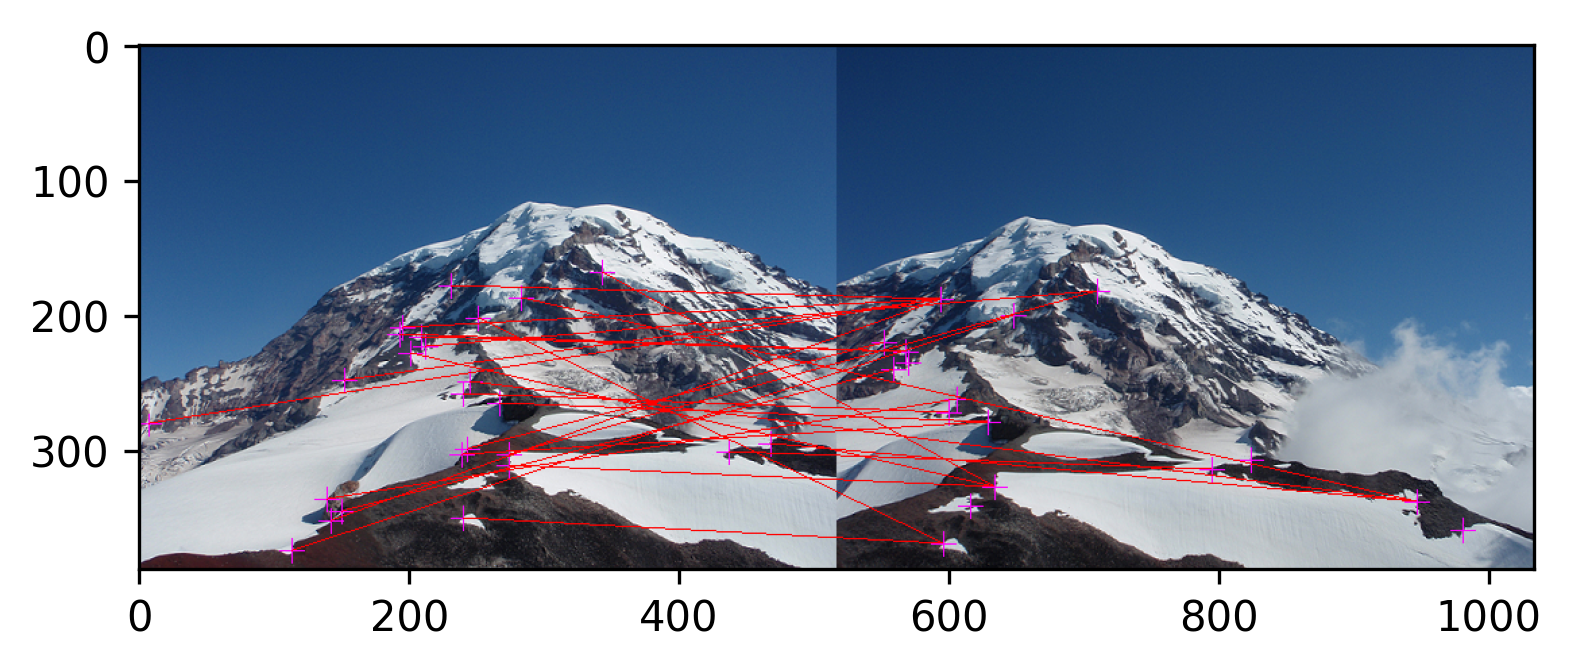

In [198]:
a = imgio.imread('/content/Rainier1.png')
b = imgio.imread('/content/Rainier2.png')
m = find_and_draw_matches(a,b,2,0.04,3)
plt.figure(dpi=300)
plt.imshow(m); plt.show()

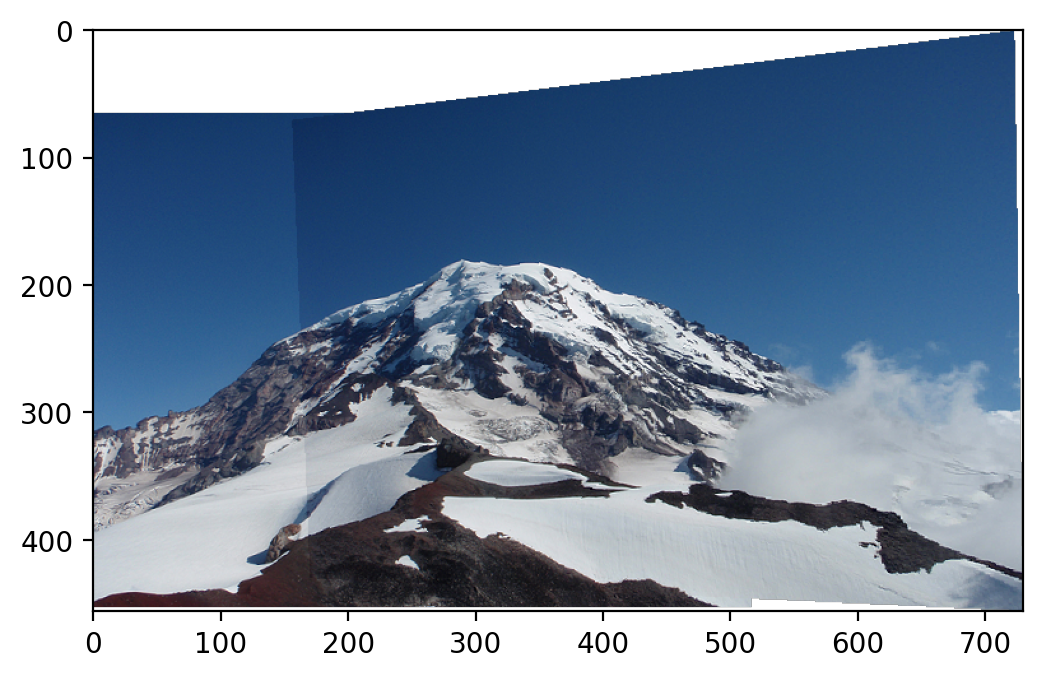

In [200]:
im1 = imgio.imread('/content/Rainier1.png')
im2 = imgio.imread('/content/Rainier2.png')
pan1 = panorama_image(im1, im2)
plt.figure(dpi=200)
plt.imshow(pan1); plt.show()

In [ ]:
im2 = imgio.imread('/content/Rainier3.png')
pan2 = panorama_image(pan1, im2)

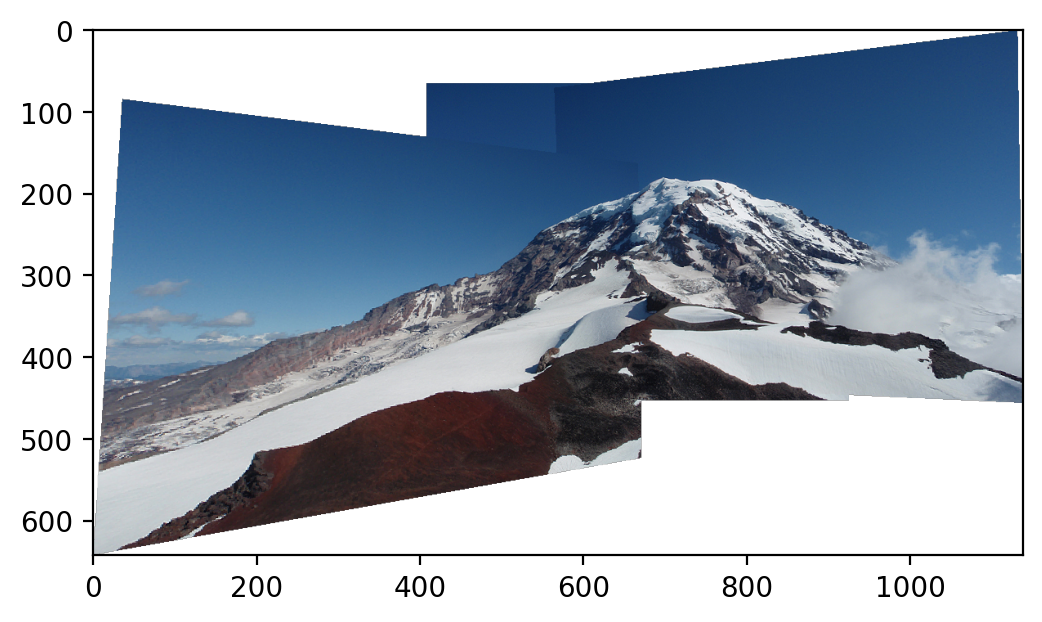

In [266]:
plt.figure(dpi=200)
plt.imshow(pan2); plt.show()